In [1]:
# Set the PySpark Connection:
import findspark
findspark.init()
findspark.find()
import pyspark
findspark.find()

'C:\\Spark\\spark-3.1.2-bin-hadoop3.2'

In [2]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName("PySpark_Basics").getOrCreate()
spark

In [102]:
# Reading Data from FILE:
file_location = "movie_data_part1.csv"
file_type = "csv"
infer_schema = "false"
first_row_is_header = "true"
delimiter = "|"

df = spark.read.format(file_type)\
.option("InferSchema", infer_schema)\
.option("header", first_row_is_header)\
.option("sep", delimiter)\
.load(file_location)

In [73]:
# Print Metadata
df.printSchema()

root
 |-- belongs_to_collection: string (nullable = true)
 |-- budget: string (nullable = true)
 |-- id: string (nullable = true)
 |-- original_language: string (nullable = true)
 |-- original_title: string (nullable = true)
 |-- overview: string (nullable = true)
 |-- popularity: string (nullable = true)
 |-- production_companies: string (nullable = true)
 |-- production_countries: string (nullable = true)
 |-- release_date: string (nullable = true)
 |-- revenue: string (nullable = true)
 |-- runtime: string (nullable = true)
 |-- status: string (nullable = true)
 |-- tagline: string (nullable = true)
 |-- title: string (nullable = true)
 |-- vote_average: string (nullable = true)



### String Functions

In [4]:
from pyspark.sql.functions import *

# String functions
df_with_newcols = df.select('id','budget','popularity').\
withColumn('budget_cat', when(df['budget']<10000000,'Small').when(df['budget']<100000000,'Medium').otherwise('Big')).\
withColumn('ratings', when(df['popularity']<3,'Low').when(df['popularity']<5,'Mid').otherwise('High'))

df_with_newcols.show(10)

+-----+------+----------+----------+-------+
|   id|budget|popularity|budget_cat|ratings|
+-----+------+----------+----------+-------+
|43000|     0|     2.503|     Small|    Low|
|43001|     0|      5.51|     Small|   High|
|43002|     0|      5.62|     Small|   High|
|43003|     0|     7.159|     Small|   High|
|43004|500000|     3.988|     Small|    Mid|
|43006|     0|     3.194|     Small|    Mid|
|43007|     0|     2.689|     Small|    Low|
|43008|     0|     6.537|     Small|   High|
|43010|     0|     4.297|     Small|    Mid|
|43011|     0|     4.417|     Small|    Mid|
+-----+------+----------+----------+-------+
only showing top 10 rows



In [6]:
# concatanating the two variables:
df_with_newcols=df_with_newcols.withColumn('BudgetRating_Category',concat(df_with_newcols.budget_cat,df_with_newcols.ratings))
df_with_newcols.show(10)

+-----+------+----------+----------+-------+---------------------+
|   id|budget|popularity|budget_cat|ratings|BudgetRating_Category|
+-----+------+----------+----------+-------+---------------------+
|43000|     0|     2.503|     Small|    Low|             SmallLow|
|43001|     0|      5.51|     Small|   High|            SmallHigh|
|43002|     0|      5.62|     Small|   High|            SmallHigh|
|43003|     0|     7.159|     Small|   High|            SmallHigh|
|43004|500000|     3.988|     Small|    Mid|             SmallMid|
|43006|     0|     3.194|     Small|    Mid|             SmallMid|
|43007|     0|     2.689|     Small|    Low|             SmallLow|
|43008|     0|     6.537|     Small|   High|            SmallHigh|
|43010|     0|     4.297|     Small|    Mid|             SmallMid|
|43011|     0|     4.417|     Small|    Mid|             SmallMid|
+-----+------+----------+----------+-------+---------------------+
only showing top 10 rows



In [7]:
# Changing the new variable to a lowercase:
df_with_newcols=df_with_newcols.withColumn('BudgetRating_Category',trim(lower(df_with_newcols.BudgetRating_Category)))
df_with_newcols.show(10)

+-----+------+----------+----------+-------+---------------------+
|   id|budget|popularity|budget_cat|ratings|BudgetRating_Category|
+-----+------+----------+----------+-------+---------------------+
|43000|     0|     2.503|     Small|    Low|             smalllow|
|43001|     0|      5.51|     Small|   High|            smallhigh|
|43002|     0|      5.62|     Small|   High|            smallhigh|
|43003|     0|     7.159|     Small|   High|            smallhigh|
|43004|500000|     3.988|     Small|    Mid|             smallmid|
|43006|     0|     3.194|     Small|    Mid|             smallmid|
|43007|     0|     2.689|     Small|    Low|             smalllow|
|43008|     0|     6.537|     Small|   High|            smallhigh|
|43010|     0|     4.297|     Small|    Mid|             smallmid|
|43011|     0|     4.417|     Small|    Mid|             smallmid|
+-----+------+----------+----------+-------+---------------------+
only showing top 10 rows



### Registering DataFrames

* Used to leverage the power of SQL functions in PySpark
* registerTempTable function creates an in-memory table
* The data is stored in hive's column format

In [8]:
# registering temporary table
df_with_newcols.registerTempTable('temp_data')

# applying the functions to show the results:
spark.sql('select ratings, count(ratings) from temp_data group by ratings').show(10, False)

+-------+--------------+
|ratings|count(ratings)|
+-------+--------------+
|High   |16856         |
|Low    |14865         |
|Mid    |12277         |
+-------+--------------+



### Window Functions

* Deciling is a process of dividing the distribution into ten equal buckets in either ascending or descending order. These are used as an input step in evaluating a predictive model's performance

* Window functions require specifying the following three important components:
    * *Partition*: This specifies which rows will be included in the same partition with the row
    * *Order*: The order of the rows (ascending or descending)
    * *Frame*: This specifies how many rows you want to include above/below the current row based on relative position to the current position

In [9]:
# Let's first check a simple example:
#  Importing the window functions:
from pyspark.sql.window import *

In [10]:
# Step 1: filtering the missing values:
df_with_newcols = df_with_newcols.filter( (df_with_newcols['popularity'].isNotNull()) & (~isnan(df_with_newcols['popularity'])))

In [11]:
# Step 2: Applying the window functions for calculating deciles:
df_with_newcols = df_with_newcols.select("id","budget","popularity", ntile(10).over(Window.partitionBy().orderBy(df_with_newcols['popularity'].desc())).alias("decile_rank"))

In [12]:
# Step 3: Displaying the values:
df_with_newcols.groupby("decile_rank").agg(min('popularity').alias('min_popularity'), max('popularity').alias('max_popularity'), count('popularity')).show()

+-----------+------------------+--------------+-----------------+
|decile_rank|    min_popularity|max_popularity|count(popularity)|
+-----------+------------------+--------------+-----------------+
|          1|             7.402|            99|             4379|
|          2|             5.792|         7.401|             4379|
|          3|             4.792|         5.792|             4379|
|          4|             4.024|         4.792|             4378|
|          5|             3.371|         4.024|             4378|
|          6|             2.779|          3.37|             4378|
|          7|             2.108|         2.779|             4378|
|          8|            10.422|         2.108|             4378|
|          9|             1.389|         10.42|             4378|
|         10|0.6000000000000001|         1.389|             4378|
+-----------+------------------+--------------+-----------------+



###### We want to find the second most popular movie in the year 1970

In [13]:
#Step 1: Import the window functions
from pyspark.sql.window import *

In [14]:
#Step 2: Select the required subset of columns
df_second_best = df.select('id','popularity','release_date')
df_second_best.show(5)

+-----+----------+------------+
|   id|popularity|release_date|
+-----+----------+------------+
|43000|     2.503|  1962-05-23|
|43001|      5.51|  1962-11-12|
|43002|      5.62|  1962-05-24|
|43003|     7.159|  1975-03-12|
|43004|     3.988|  1962-10-09|
+-----+----------+------------+
only showing top 5 rows



In [15]:
#Step 3: Create the year column from release date
df_second_best = df_second_best.withColumn('release_year',year('release_date')).drop('release_date')
df_second_best.show(5)

+-----+----------+------------+
|   id|popularity|release_year|
+-----+----------+------------+
|43000|     2.503|        1962|
|43001|      5.51|        1962|
|43002|      5.62|        1962|
|43003|     7.159|        1975|
|43004|     3.988|        1962|
+-----+----------+------------+
only showing top 5 rows



In [16]:
#Step 4: Define partition function
year_window = Window.partitionBy(df_second_best['release_year']).orderBy(df_with_newcols['popularity'].desc())

In [17]:
#Step 5: Apply partion function
df_second_best = df_second_best.select('id','popularity','release_year',rank().over(year_window).alias("rank"))
df_second_best.show(5)

+-----+-----------------+------------+----+
|   id|       popularity|release_year|rank|
+-----+-----------------+------------+----+
|11571|            9.808|        1959|   1|
|14698|9.806000000000001|        1959|   2|
|   93|            9.476|        1959|   3|
|  690|            9.409|        1959|   4|
|62036|            9.324|        1959|   5|
+-----+-----------------+------------+----+
only showing top 5 rows



In [18]:
# Step 6: find the second most popular movie in the year 1970
df_second_best.filter( (df_second_best['release_year']==1970) & (df_second_best['rank']==2)).show()

+---+----------+------------+----+
| id|popularity|release_year|rank|
+---+----------+------------+----+
|651|     9.588|        1970|   2|
+---+----------+------------+----+



###### What is the difference between the revenue  of the highest-grossing film of the year and other films within that year?

In [19]:
#Step 1: Import the window functions
from pyspark.sql.window import *

In [20]:
#Step 2: Select the required subset of columns
df_revenue = df.select('id','revenue','release_date')
df_revenue.show(5)

+-----+-------+------------+
|   id|revenue|release_date|
+-----+-------+------------+
|43000|      0|  1962-05-23|
|43001|      0|  1962-11-12|
|43002|      0|  1962-05-24|
|43003|      0|  1975-03-12|
|43004|      0|  1962-10-09|
+-----+-------+------------+
only showing top 5 rows



In [21]:
#Step 3: Create the year column from release date
df_revenue = df_revenue.withColumn('release_year',year('release_date')).drop('release_date')
df_revenue.show(5)

+-----+-------+------------+
|   id|revenue|release_year|
+-----+-------+------------+
|43000|      0|        1962|
|43001|      0|        1962|
|43002|      0|        1962|
|43003|      0|        1975|
|43004|      0|        1962|
+-----+-------+------------+
only showing top 5 rows



In [22]:
#Step 4: Define partition function
windowRev =Window.partitionBy(df_revenue['release_year']).orderBy(df_revenue['revenue'].desc()).rangeBetween(-sys.maxsize, sys.maxsize)

In [23]:
#Step 5: Apply partition function for the revenue differences
revenue_difference = (max(df_revenue['revenue']).over(windowRev) - df_revenue['revenue']) 

In [24]:
#Step 6: Final data
df_revenue.select('id','revenue','release_year',revenue_difference.alias("revenue_difference")).show(10, False)

+-----+---------+------------+------------------+
|id   |revenue  |release_year|revenue_difference|
+-----+---------+------------+------------------+
|9660 |6800000  |1959        |0.0               |
|301  |5800000  |1959        |1000000.0         |
|10882|51000000 |1959        |-4.42E7           |
|76863|3745000  |1959        |3055000.0         |
|5544 |3193     |1959        |6796807.0         |
|239  |25000000 |1959        |-1.82E7           |
|4952 |18750000 |1959        |-1.195E7          |
|15944|17658000 |1959        |-1.0858E7         |
|665  |164000000|1959        |-1.572E8          |
|896  |134241   |1959        |6665759.0         |
+-----+---------+------------+------------------+
only showing top 10 rows



### Collect List

In [25]:
#Frequencies - descending order
df.groupby(df['title']).count().sort(desc("count")).show(20)

+--------------------+-----+
|               title|count|
+--------------------+-----+
|                null|  304|
|          Cinderella|    8|
|The Three Musketeers|    8|
|      Les Misérables|    8|
|             Dracula|    7|
|   A Christmas Carol|    7|
|        Frankenstein|    7|
|          The Island|    7|
|              Hamlet|    7|
|           Cleopatra|    6|
|              Framed|    6|
|          First Love|    6|
|     Treasure Island|    6|
|Crime and Punishment|    6|
|Beauty and the Beast|    6|
|          Borderline|    6|
|      The Lost World|    6|
|The Hound of the ...|    6|
|Dr. Jekyll and Mr...|    5|
|         The Visitor|    5|
+--------------------+-----+
only showing top 20 rows



In [26]:
# The above example can be simplified by using the collect_list function
# We can find all years where the title "The Lost World" is repeated

# Step 1: Create the year column from release date:
df = df.withColumn('release_year', year('release_date'))
df.show(5)

+---------------------+------+-----+-----------------+--------------------+--------------------+----------+--------------------+--------------------+------------+-------+-------+--------+--------------------+--------------------+------------+------------+
|belongs_to_collection|budget|   id|original_language|      original_title|            overview|popularity|production_companies|production_countries|release_date|revenue|runtime|  status|             tagline|               title|vote_average|release_year|
+---------------------+------+-----+-----------------+--------------------+--------------------+----------+--------------------+--------------------+------------+-------+-------+--------+--------------------+--------------------+------------+------------+
|                 null|     0|43000|               fr|  Le Caporal épinglé|The story serves ...|     2.503|[{'id': 16059, 'l...|[{'iso_3166_1': '...|  1962-05-23|      0|     90|Released|                null|The Elusive Corporal|   

In [27]:
# Step 2: Apply collect list function to gather all occurrences;
df.filter("title == 'The Lost World'").groupby('title').agg(collect_list("release_year")).show(1, False)

+--------------+------------------------------------+
|title         |collect_list(release_year)          |
+--------------+------------------------------------+
|The Lost World|[1999, 2001, 1925, 1960, 1992, 1998]|
+--------------+------------------------------------+



### Sampling

##### Simple Random Sample without Replacement 

In [29]:
# False: without replacement
# 0.4: percent selection (40% sample)
# 11: seed
df_sample = df.sample(False, 0.4, 11)
df_sample.count()

17684

##### Simple Random Sample with Replacement 

In [30]:
df_sample = df.sample(True, 0.4, 11)
df_sample.count()

17805

##### Stratified Sampling:

In [31]:
df_strat = df.sampleBy("release_year", fractions={1959: 0.2, 1960: 0.4, 1961: 0.4}, seed = 11)
df_strat.count()

241

### Caching and Persisting

* MEMORY_ONLY
* MEMORY_ONLY_SER
* MEMORY_AND_DISK
* MEMORY_AND_DISK_SER

SER: Serialized Java Objects (one byte array per partition)

In [32]:
# default: MEMORY_ONLY
df.cache()

DataFrame[belongs_to_collection: string, budget: string, id: string, original_language: string, original_title: string, overview: string, popularity: string, production_companies: string, production_countries: string, release_date: string, revenue: string, runtime: string, status: string, tagline: string, title: string, vote_average: string, release_year: int]

In [45]:
# check if the dataframe is cached:
df.is_cached

True

In [33]:
df.persist()

DataFrame[belongs_to_collection: string, budget: string, id: string, original_language: string, original_title: string, overview: string, popularity: string, production_companies: string, production_countries: string, release_date: string, revenue: string, runtime: string, status: string, tagline: string, title: string, vote_average: string, release_year: int]

In [38]:
df.persist(pyspark.StorageLevel.MEMORY_ONLY)

DataFrame[belongs_to_collection: string, budget: string, id: string, original_language: string, original_title: string, overview: string, popularity: string, production_companies: string, production_countries: string, release_date: string, revenue: string, runtime: string, status: string, tagline: string, title: string, vote_average: string, release_year: int]

In [40]:
df.persist(pyspark.StorageLevel.DISK_ONLY)

DataFrame[belongs_to_collection: string, budget: string, id: string, original_language: string, original_title: string, overview: string, popularity: string, production_companies: string, production_countries: string, release_date: string, revenue: string, runtime: string, status: string, tagline: string, title: string, vote_average: string, release_year: int]

In [41]:
df.persist(pyspark.StorageLevel.MEMORY_AND_DISK)

DataFrame[belongs_to_collection: string, budget: string, id: string, original_language: string, original_title: string, overview: string, popularity: string, production_companies: string, production_countries: string, release_date: string, revenue: string, runtime: string, status: string, tagline: string, title: string, vote_average: string, release_year: int]

In [48]:
df.unpersist()

DataFrame[belongs_to_collection: string, budget: string, id: string, original_language: string, original_title: string, overview: string, popularity: string, production_companies: string, production_countries: string, release_date: string, revenue: string, runtime: string, status: string, tagline: string, title: string, vote_average: string, release_year: int]

In [49]:
df.storageLevel

StorageLevel(False, False, False, False, 1)

In [51]:
# if we use any of the levels with _2, it represents that the 
# data is persisted and each is replicated into two cluster nodes. 
df.persist(pyspark.StorageLevel.MEMORY_AND_DISK_2)

DataFrame[belongs_to_collection: string, budget: string, id: string, original_language: string, original_title: string, overview: string, popularity: string, production_companies: string, production_countries: string, release_date: string, revenue: string, runtime: string, status: string, tagline: string, title: string, vote_average: string, release_year: int]

In [52]:
df.storageLevel

StorageLevel(True, True, False, False, 2)

In [53]:
df.unpersist()

DataFrame[belongs_to_collection: string, budget: string, id: string, original_language: string, original_title: string, overview: string, popularity: string, production_companies: string, production_countries: string, release_date: string, revenue: string, runtime: string, status: string, tagline: string, title: string, vote_average: string, release_year: int]

### Pandas Support

In [55]:
# Pandas to PySpark
df_pandas = df.toPandas()
df_pandas.head(5)

,belongs_to_collection,budget,id,original_language,original_title,overview,popularity,production_companies,production_countries,release_date,revenue,runtime,status,tagline,title,vote_average,release_year
0,None,0,43000,fr,Le Caporal épinglé,The story serves as a companion piece to Renoi...,2.503,"[{'id': 16059, 'logo_path': None, 'name': 'Les...","[{'iso_3166_1': 'FR', 'name': 'France'}]",1962-05-23,0,90,Released,None,The Elusive Corporal,5.9,1962.0
1,None,0,43001,fr,Cybèle ou les dimanches de ville d'Avray,The tragic story of a young orphan girl who is...,5.51,"[{'id': 7808, 'logo_path': None, 'name': 'Fidè...","[{'iso_3166_1': 'AT', 'name': 'Austria'}, {'is...",1962-11-12,0,110,Released,None,Sundays and Cybele,7.4,1962.0
2,None,0,43002,en,Lonely Are the Brave,A fiercely independent cowboy arranges to have...,5.62,"[{'id': 3810, 'logo_path': None, 'name': 'Joel...","[{'iso_3166_1': 'US', 'name': 'United States o...",1962-05-24,0,107,Released,Life can never cage a man like this!,Lonely Are the Brave,7.5,1962.0
3,None,0,43003,fr,Vérités et Mensonges,Documents the lives of infamous fakers Elmyr d...,7.159,"[{'id': 36547, 'logo_path': None, 'name': 'SAC...","[{'iso_3166_1': 'DE', 'name': 'Germany'}, {'is...",1975-03-12,0,89,Released,None,F for Fake,7.5,1975.0
4,None,500000,43004,en,Long Day's Journey Into Night,The film follows one day in the lives of the T...,3.988,"[{'id': 77598, 'logo_path': None, 'name': 'Fir...","[{'iso_3166_1': 'US', 'name': 'United States o...",1962-10-09,0,174,Released,PRIDE...POWER...PASSION...PAIN!,Long Day's Journey Into Night,6.8,1962.0


In [57]:
# Pandas to PySpark
df_py = spark.createDataFrame(df_pandas)
df_py

DataFrame[belongs_to_collection: string, budget: string, id: string, original_language: string, original_title: string, overview: string, popularity: string, production_companies: string, production_countries: string, release_date: string, revenue: string, runtime: string, status: string, tagline: string, title: string, vote_average: string, release_year: double]

### Joins

In [71]:
# Reading another new dataset for joins: 

# Input parameters:
file_location = "movie_data_part2.csv"
file_type = "csv"
infer_schema = "False"
first_row_is_header = "True"
delimiter = "|"

# Bringing all the options together to read the csv file: 
df_p1 = spark.read.format(file_type) \
.option("inferSchema", infer_schema) \
.option("header", first_row_is_header) \
.option("sep", delimiter) \
.load(file_location)

In [72]:
# Print Metadata
df_p1.printSchema()

root
 |-- cast: string (nullable = true)
 |-- adult: string (nullable = true)
 |-- directors: string (nullable = true)
 |-- vote_count: string (nullable = true)
 |-- spoken_languages: string (nullable = true)
 |-- poster_path: string (nullable = true)
 |-- homepage: string (nullable = true)
 |-- imdb_id: string (nullable = true)
 |-- genres: string (nullable = true)
 |-- video: string (nullable = true)
 |-- id: string (nullable = true)



In [77]:
# Print Metadata
df.printSchema()

root
 |-- belongs_to_collection: string (nullable = true)
 |-- budget: string (nullable = true)
 |-- id: string (nullable = true)
 |-- original_language: string (nullable = true)
 |-- original_title: string (nullable = true)
 |-- overview: string (nullable = true)
 |-- popularity: string (nullable = true)
 |-- production_companies: string (nullable = true)
 |-- production_countries: string (nullable = true)
 |-- release_date: string (nullable = true)
 |-- revenue: string (nullable = true)
 |-- runtime: string (nullable = true)
 |-- status: string (nullable = true)
 |-- tagline: string (nullable = true)
 |-- title: string (nullable = true)
 |-- vote_average: string (nullable = true)
 |-- release_year: integer (nullable = true)



In [78]:
# Cast identifer into the right datatype:
df = df.withColumn('id', df['id'].cast("integer"))
df.printSchema()

root
 |-- belongs_to_collection: string (nullable = true)
 |-- budget: string (nullable = true)
 |-- id: integer (nullable = true)
 |-- original_language: string (nullable = true)
 |-- original_title: string (nullable = true)
 |-- overview: string (nullable = true)
 |-- popularity: string (nullable = true)
 |-- production_companies: string (nullable = true)
 |-- production_countries: string (nullable = true)
 |-- release_date: string (nullable = true)
 |-- revenue: string (nullable = true)
 |-- runtime: string (nullable = true)
 |-- status: string (nullable = true)
 |-- tagline: string (nullable = true)
 |-- title: string (nullable = true)
 |-- vote_average: string (nullable = true)
 |-- release_year: integer (nullable = true)



In [84]:
dfc = df.count()
print(f'Counting the original dataframe: {dfc}')

Counting the original dataframe: 43998


In [73]:
df_p1.show(5)

+--------------------+-----+--------------------+----------+--------------------+--------------------+--------+---------+--------------------+-----+-----+
|                cast|adult|           directors|vote_count|    spoken_languages|         poster_path|homepage|  imdb_id|              genres|video|   id|
+--------------------+-----+--------------------+----------+--------------------+--------------------+--------+---------+--------------------+-----+-----+
|[{'cast_id': 3, '...|False|[{'credit_id': '5...|        10|[{'iso_639_1': 'f...|/un7u35GYAmpnfvdS...|    null|tt0055827|[{'id': 35, 'name...|False|43000|
|"[{'cast_id': 4, ...|False|[{'credit_id': '5...|        26|[{'iso_639_1': 'f...|/sTx0bYeq1OtKOGZS...|    null|tt0055910|[{'id': 18, 'name...|False|43001|
|"[{'cast_id': 1, ...|False|[{'credit_id': '5...|        65|[{'iso_639_1': 'e...|/h5gaDp7FurCVfUCI...|    null|tt0056195|[{'id': 18, 'name...|False|43002|
|[{'cast_id': 3, '...|False|[{'credit_id': '5...|       173|[{'iso_639

In [74]:
# Preparing data for joins
# Cast identifer into the right datatype:
df_p1 = df_p1.withColumn('id', df_p1['id'].cast("integer"))
df_p1.printSchema()

root
 |-- cast: string (nullable = true)
 |-- adult: string (nullable = true)
 |-- directors: string (nullable = true)
 |-- vote_count: string (nullable = true)
 |-- spoken_languages: string (nullable = true)
 |-- poster_path: string (nullable = true)
 |-- homepage: string (nullable = true)
 |-- imdb_id: string (nullable = true)
 |-- genres: string (nullable = true)
 |-- video: string (nullable = true)
 |-- id: integer (nullable = true)



In [79]:
# Filter missing values:
bc = df_p1.count()
print(f'Before cleaning: {bc}')

df_p1 = df_p1.filter((df_p1['id'].isNotNull()) & (~isnan(df_p1['id'])))
ac= df_p1.count()
print(f'After cleaning: {ac}')

Before cleaning: 24998
After cleaning: 24998


##### inner join

* This joins both DataFrames on the identifier and retains only the common rows and columns 

In [80]:
df.join(df_p1, df['id'] == df_p1['id'], 'inner').printSchema()

root
 |-- belongs_to_collection: string (nullable = true)
 |-- budget: string (nullable = true)
 |-- id: integer (nullable = true)
 |-- original_language: string (nullable = true)
 |-- original_title: string (nullable = true)
 |-- overview: string (nullable = true)
 |-- popularity: string (nullable = true)
 |-- production_companies: string (nullable = true)
 |-- production_countries: string (nullable = true)
 |-- release_date: string (nullable = true)
 |-- revenue: string (nullable = true)
 |-- runtime: string (nullable = true)
 |-- status: string (nullable = true)
 |-- tagline: string (nullable = true)
 |-- title: string (nullable = true)
 |-- vote_average: string (nullable = true)
 |-- release_year: integer (nullable = true)
 |-- cast: string (nullable = true)
 |-- adult: string (nullable = true)
 |-- directors: string (nullable = true)
 |-- vote_count: string (nullable = true)
 |-- spoken_languages: string (nullable = true)
 |-- poster_path: string (nullable = true)
 |-- homepage: s

In [81]:
df.join(df_p1, df['id'] == df_p1['id'], 'inner').count()

24998

##### Left/Left outer join

In [82]:
df.join(df_p1, df['id'] == df_p1['id'],'left').printSchema()

root
 |-- belongs_to_collection: string (nullable = true)
 |-- budget: string (nullable = true)
 |-- id: integer (nullable = true)
 |-- original_language: string (nullable = true)
 |-- original_title: string (nullable = true)
 |-- overview: string (nullable = true)
 |-- popularity: string (nullable = true)
 |-- production_companies: string (nullable = true)
 |-- production_countries: string (nullable = true)
 |-- release_date: string (nullable = true)
 |-- revenue: string (nullable = true)
 |-- runtime: string (nullable = true)
 |-- status: string (nullable = true)
 |-- tagline: string (nullable = true)
 |-- title: string (nullable = true)
 |-- vote_average: string (nullable = true)
 |-- release_year: integer (nullable = true)
 |-- cast: string (nullable = true)
 |-- adult: string (nullable = true)
 |-- directors: string (nullable = true)
 |-- vote_count: string (nullable = true)
 |-- spoken_languages: string (nullable = true)
 |-- poster_path: string (nullable = true)
 |-- homepage: s

In [83]:
df.join(df_p1, df['id'] == df_p1['id'],'left').count()

43998

##### Right/Right outer join

In [85]:
df.join(df_p1, df['id'] == df_p1['id'],'right').printSchema()

root
 |-- belongs_to_collection: string (nullable = true)
 |-- budget: string (nullable = true)
 |-- id: integer (nullable = true)
 |-- original_language: string (nullable = true)
 |-- original_title: string (nullable = true)
 |-- overview: string (nullable = true)
 |-- popularity: string (nullable = true)
 |-- production_companies: string (nullable = true)
 |-- production_countries: string (nullable = true)
 |-- release_date: string (nullable = true)
 |-- revenue: string (nullable = true)
 |-- runtime: string (nullable = true)
 |-- status: string (nullable = true)
 |-- tagline: string (nullable = true)
 |-- title: string (nullable = true)
 |-- vote_average: string (nullable = true)
 |-- release_year: integer (nullable = true)
 |-- cast: string (nullable = true)
 |-- adult: string (nullable = true)
 |-- directors: string (nullable = true)
 |-- vote_count: string (nullable = true)
 |-- spoken_languages: string (nullable = true)
 |-- poster_path: string (nullable = true)
 |-- homepage: s

In [86]:
df.join(df_p1, df['id'] == df_p1['id'],'right').count()

24998

##### Full outer join

In [87]:
df.join(df_p1, df['id'] == df_p1['id'],'outer').printSchema()

root
 |-- belongs_to_collection: string (nullable = true)
 |-- budget: string (nullable = true)
 |-- id: integer (nullable = true)
 |-- original_language: string (nullable = true)
 |-- original_title: string (nullable = true)
 |-- overview: string (nullable = true)
 |-- popularity: string (nullable = true)
 |-- production_companies: string (nullable = true)
 |-- production_countries: string (nullable = true)
 |-- release_date: string (nullable = true)
 |-- revenue: string (nullable = true)
 |-- runtime: string (nullable = true)
 |-- status: string (nullable = true)
 |-- tagline: string (nullable = true)
 |-- title: string (nullable = true)
 |-- vote_average: string (nullable = true)
 |-- release_year: integer (nullable = true)
 |-- cast: string (nullable = true)
 |-- adult: string (nullable = true)
 |-- directors: string (nullable = true)
 |-- vote_count: string (nullable = true)
 |-- spoken_languages: string (nullable = true)
 |-- poster_path: string (nullable = true)
 |-- homepage: s

In [88]:
df.join(df_p1, df['id'] == df_p1['id'],'outer').count()

43998

##### Left Anti join

In [89]:
df.join(df_p1, df['id'] == df_p1['id'],'left_anti').printSchema()

root
 |-- belongs_to_collection: string (nullable = true)
 |-- budget: string (nullable = true)
 |-- id: integer (nullable = true)
 |-- original_language: string (nullable = true)
 |-- original_title: string (nullable = true)
 |-- overview: string (nullable = true)
 |-- popularity: string (nullable = true)
 |-- production_companies: string (nullable = true)
 |-- production_countries: string (nullable = true)
 |-- release_date: string (nullable = true)
 |-- revenue: string (nullable = true)
 |-- runtime: string (nullable = true)
 |-- status: string (nullable = true)
 |-- tagline: string (nullable = true)
 |-- title: string (nullable = true)
 |-- vote_average: string (nullable = true)
 |-- release_year: integer (nullable = true)



In [90]:
df.join(df_p1, df['id'] == df_p1['id'],'left_anti').count()

19000

##### Left Semi Join
* This is similar to an inner join, except it would not yield the columns from the right-hand DataFrame

In [91]:
df.join(df_p1, df['id'] == df_p1['id'],'left_semi').printSchema()

root
 |-- belongs_to_collection: string (nullable = true)
 |-- budget: string (nullable = true)
 |-- id: integer (nullable = true)
 |-- original_language: string (nullable = true)
 |-- original_title: string (nullable = true)
 |-- overview: string (nullable = true)
 |-- popularity: string (nullable = true)
 |-- production_companies: string (nullable = true)
 |-- production_countries: string (nullable = true)
 |-- release_date: string (nullable = true)
 |-- revenue: string (nullable = true)
 |-- runtime: string (nullable = true)
 |-- status: string (nullable = true)
 |-- tagline: string (nullable = true)
 |-- title: string (nullable = true)
 |-- vote_average: string (nullable = true)
 |-- release_year: integer (nullable = true)



In [92]:
df.join(df_p1, df['id'] == df_p1['id'],'left_semi').count()

24998

##### Broadcasting
* There will be situations when you have to join one large dataset (millions of rows) and one small dataset (hundreds of rows). To join them efficiently, Spark has another function called **broadcast**. The smaller DataFrame will be replicated in all the nodes of the cluster. This improves efficiency, as Spark doesn't need to do any shuffling in the larger dataset.

In [94]:
df.join(broadcast(df_p1), df['id'] == df_p1['id'],'outer').count()

43998

### Dropping Duplicates

In [69]:
# original data count:
df.count()

43998

In [66]:
# dropping the duplicates
# In the below example, we drop the rows for which movie title and release years are the same
df.dropDuplicates(['title','release_year']).count()

43643

### Data Visualizations

##### Number of Movies Released between 1960 and 1970 (by Year):

In [95]:
# Step 1: Import the required libraries
%matplotlib inline
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns

In [106]:
df=df.select(df[2],df[1],df[6],df[9],df[10],df[14])
df.show()

+-----+-------+------------------+------------+-------+--------------------+
|   id| budget|        popularity|release_date|revenue|               title|
+-----+-------+------------------+------------+-------+--------------------+
|43000|      0|             2.503|  1962-05-23|      0|The Elusive Corporal|
|43001|      0|              5.51|  1962-11-12|      0|  Sundays and Cybele|
|43002|      0|              5.62|  1962-05-24|      0|Lonely Are the Brave|
|43003|      0|             7.159|  1975-03-12|      0|          F for Fake|
|43004| 500000|             3.988|  1962-10-09|      0|Long Day's Journe...|
|43006|      0|             3.194|  1962-03-09|      0|           My Geisha|
|43007|      0|             2.689|  1962-10-31|      0|Period of Adjustment|
|43008|      0|             6.537|  1959-03-13|      0|    The Hanging Tree|
|43010|      0|             4.297|  1962-01-01|      0|Sherlock Holmes a...|
|43011|      0|             4.417|  1962-01-01|      0|  Sodom and Gomorrah|

In [109]:
df_temp=df.withColumn('release_year',year('release_date'))
df_temp.show()

+-----+-------+------------------+------------+-------+--------------------+------------+
|   id| budget|        popularity|release_date|revenue|               title|release_year|
+-----+-------+------------------+------------+-------+--------------------+------------+
|43000|      0|             2.503|  1962-05-23|      0|The Elusive Corporal|        1962|
|43001|      0|              5.51|  1962-11-12|      0|  Sundays and Cybele|        1962|
|43002|      0|              5.62|  1962-05-24|      0|Lonely Are the Brave|        1962|
|43003|      0|             7.159|  1975-03-12|      0|          F for Fake|        1975|
|43004| 500000|             3.988|  1962-10-09|      0|Long Day's Journe...|        1962|
|43006|      0|             3.194|  1962-03-09|      0|           My Geisha|        1962|
|43007|      0|             2.689|  1962-10-31|      0|Period of Adjustment|        1962|
|43008|      0|             6.537|  1959-03-13|      0|    The Hanging Tree|        1959|
|43010|   

In [110]:
# Step 2: Preparing the data using spark funcstions and converting to pandas DataFrame:
df_cat=df_temp.filter("(release_year > 1959) and (release_year < 1971)").groupby('release_year').count().toPandas()

# Step 3: Sorting the values for display:
df_cat=df_cat.sort_values(by=['release_year'], ascending=False)

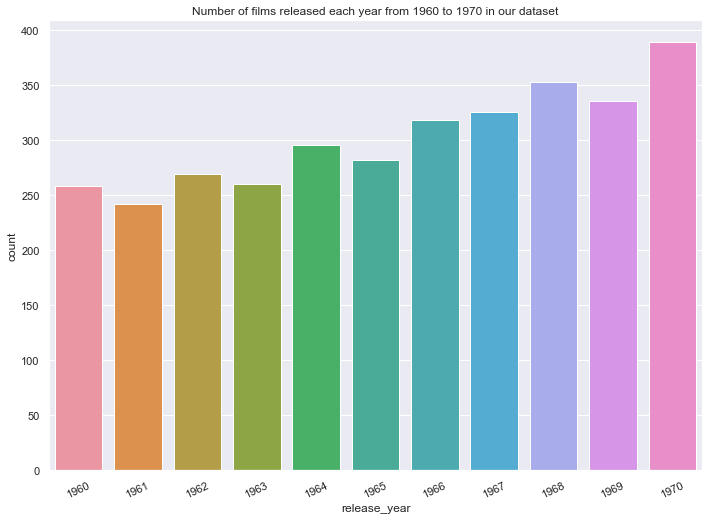

In [111]:
# Step 4: Plotting the data
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.barplot(df_cat['release_year'],df_cat['count'])
plt.xticks(rotation=25)
plt.title('Number of films released each year from 1960 to 1970 in our dataset')
plt.show()
# plt.savefig('myimage2.svg', format='svg', dpi=1200)

# Great Job!!